<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/coiled_pytorch_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dask + coiled + pytorch + colab (oh my!)

This is based on 
https://examples.dask.org/machine-learning/torch-prediction.html
but modified so that the dask client uses a cluster setup using coiled.io, as explained here
https://docs.coiled.io/user_guide/getting_started.html



## Install coiled

In [1]:
!pip install coiled


     |████████████████████████████████| 7.3MB 15.0MB/s 
ERROR: aiobotocore 1.2.1 has requirement botocore<1.19.53,>=1.19.52, but you'll have botocore 1.20.17 which is incompatible.
  Found existing installation: botocore 1.19.52
    Uninstalling botocore-1.19.52:
      Successfully uninstalled botocore-1.19.52


In [2]:
!coiled login


Please login to https://cloud.coiled.io/profile to get your token
Token: 
Authentication successful
Credentials have been saved at /root/.config/dask/coiled.yaml


In [3]:
'''
import coiled

#  https://cloud.coiled.io/examples/software/hyperband-optimization
cluster = coiled.Cluster(
    n_workers=2, #10 # use 2 to make startup time faster
    software="examples/hyperband-optimization", # we pick this envrionment since it contains pytorch, but it relies on python3.8
)

'''

Creating Cluster. This takes about a minute ...Checking environment images
Valid environment image found


/usr/local/lib/python3.7/dist-packages/distributed/client.py:1135: VersionMismatchWarning: Mismatched versions found

+---------+----------------+---------------+---------------+
| Package | client         | scheduler     | workers       |
+---------+----------------+---------------+---------------+
| numpy   | 1.19.5         | 1.20.1        | 1.20.1        |
| python  | 3.7.10.final.0 | 3.8.6.final.0 | 3.8.6.final.0 |
| tornado | 5.1.1          | 6.1           | 6.1           |
+---------+----------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [5]:
# This takes ~10mins. Only needs to be run once.

'''
import coiled

env = coiled.create_software_environment(
    name="pytorch-finetuning-37", 
    conda={
        "channels": ["conda-forge", "pytorch", "defaults"], 
        "dependencies": ["coiled=0.0.36", "dask-ml", "dask>=2.29.0", "matplotlib", "numpy", "pandas>=1.1.0", 
                         "python=3.7", # match colab
                         "pytorch>1.1.0", "s3fs", "scipy", "skorch"]
    }
)
'''




Updating software environment...
Solving conda environment...
Conda environment solved!
Building Docker image
(this takes a few minutes)
STEP 1: FROM coiled/default:sha-9aa53a2
STEP 2: COPY environment.yml environment.yml
--> Using cache c963d80e406fcd483982ee5085d4072d67fea27144d5c35223dc7122ed858c6a
--> c963d80e406
STEP 3: RUN conda env update -n coiled -f environment.yml     && rm environment.yml     && conda clean --all -y     && echo "conda activate coiled" >> ~/.bashrc
Solving environment: ...working... done

krb5-1.17.2          | 1.4 MB    | ########## | 100%
chardet-3.0.4        | 170 KB    | ########## | 100%
pygments-2.8.0       | 736 KB    | ########## | 100%
kiwisolver-1.3.1     | 78 KB     | ########## | 100%
libstdcxx-ng-9.3.0   | 4.0 MB    | ########## | 100%
attrs-20.3.0         | 41 KB     | ########## | 100%
openssl-1.1.1j       | 2.1 MB    | ########## | 100%
cycler-0.10.0        | 9 KB      | ########## | 100%
libwebp-base-1.2.0   | 808 KB    | ########## | 100%
lz

ValueError: ignored

In [6]:
cluster = coiled.Cluster(
    n_workers=2, #10 # use 2 to make startup time faster
    name = "pytorch-finetuning-37",
    software = "pytorch-finetuning-37"
)

Creating Cluster. This takes about a minute ...Checking environment images
Valid environment image found


In [7]:

import dask.distributed
client = dask.distributed.Client(cluster)
print(client)
print(client.dashboard_link)

<Client: 'tls://10.2.11.168:8786' processes=2 threads=8, memory=34.36 GB>
http://ec2-18-224-63-92.us-east-2.compute.amazonaws.com:8787


/usr/local/lib/python3.7/dist-packages/distributed/client.py:1135: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.19.5 | 1.20.1    | 1.20.1  |
| tornado | 5.1.1  | 6.1       | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


## Clone pyProbml

We need access to https://github.com/probml/pyprobml/blob/master/scripts/tutorial_helper.py which is a copy of https://github.com/dask/dask-examples/blob/main/machine-learning/tutorial_helper.py

(Alternatively we could clone https://github.com/dask/dask-examples.git)

In [8]:

!git clone https://github.com/probml/pyprobml 
%cd pyprobml/scripts

fatal: destination path 'pyprobml' already exists and is not an empty directory.
/content/pyprobml/scripts


## Download data

In [9]:
# from 
# https://examples.dask.org/machine-learning/torch-prediction.html

import urllib.request
import zipfile

filename, _ = urllib.request.urlretrieve("https://download.pytorch.org/tutorial/hymenoptera_data.zip", "data.zip")
zipfile.ZipFile(filename).extractall()
  

In [10]:
!pwd

/content/pyprobml/scripts


In [11]:
!ls h*

hbayes_bernoulli_bap_pymc3.py	   healthy_levels_plot.py
hbayes_bernoulli_covid_pymc3.py    height_weight_whiten_plot.py
hbayes_binom_covid_pymc3.py	   hinge_loss_plot.py
hbayes_binom_covid_uninf_pymc3.py  hinton_diagram.py
hbayes_binom_rats_pymc3.py	   huber_loss_plot.py

healthy-levels:
README.md  rectangle_estimation  setup.py

hymenoptera_data:
train  val


## Pytorch model

Epoch 0/1
----------
train Loss: 0.6195 Acc: 0.6352
val Loss: 0.2444 Acc: 0.9216

Epoch 1/1
----------
train Loss: 0.5092 Acc: 0.7459
val Loss: 0.2427 Acc: 0.9216

Training complete in 0m 4s
Best val Acc: 0.921569


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e6ca64f90>,
      dtype=object)

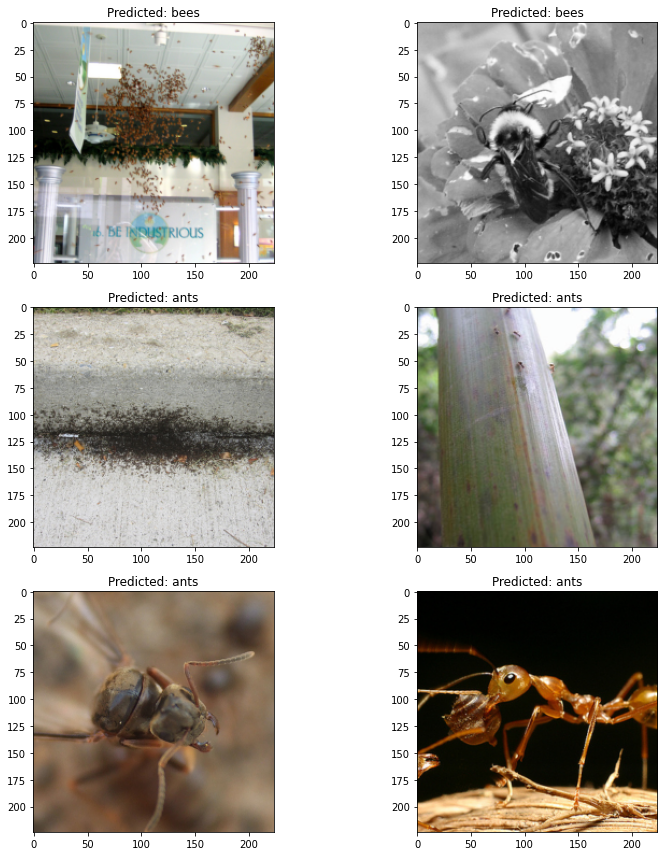

In [12]:
import torchvision
from tutorial_helper import (imshow, train_model, visualize_model,
                             dataloaders, class_names, finetune_model)

import dask

model = finetune_model()

visualize_model(model)

## Lazy data

In [13]:
# Loading the data on the workers


import glob
import toolz
import dask
import dask.array as da
import torch
from torchvision import transforms
from PIL import Image


@dask.delayed
def load(path, fs=__builtins__):
    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        return img


@dask.delayed
def transform(img):
    trn = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return trn(img)

objs = [load(x) for x in glob.glob("hymenoptera_data/val/*/*.jpg")]

tensors = [transform(x) for x in objs]

batches = [dask.delayed(torch.stack)(batch)
           for batch in toolz.partition_all(10, tensors)]

print(batches[:5])



[Delayed('stack-9adc6cb1-0b11-4d85-a9b3-43d4ea1f5cbb'), Delayed('stack-ed538a07-0221-459f-9e43-8316b8b389fc'), Delayed('stack-223c9013-bb64-499a-b31b-e940258db796'), Delayed('stack-9249033f-e1c0-4d76-b77c-ef266d8f9f10'), Delayed('stack-7b9df2fb-a02b-40d0-bceb-fc5b16e1d5ee')]


## Eager data

In [22]:
def load_eager(path, fs=__builtins__):
    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        return img

def transform_eager(img):
    trn = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return trn(img)

objs_eager = [load_eager(x) for x in glob.glob("hymenoptera_data/val/*/*.jpg")]

tensors_eager = [transform_eager(x) for x in objs_eager]



In [23]:
print(type(tensors_eager))
print(len(tensors_eager))
print(tensors_eager[0].shape)

<class 'list'>
153
torch.Size([3, 224, 224])


## Lazy model

In [14]:


import pickle

print(dask.utils.format_bytes(len(pickle.dumps(model))))


dmodel = dask.delayed(model.cpu()) # ensuring model is on the CPU

44.80 MB


## Lazy predictions

In [15]:

@dask.delayed
def predict(batch, model):
    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted

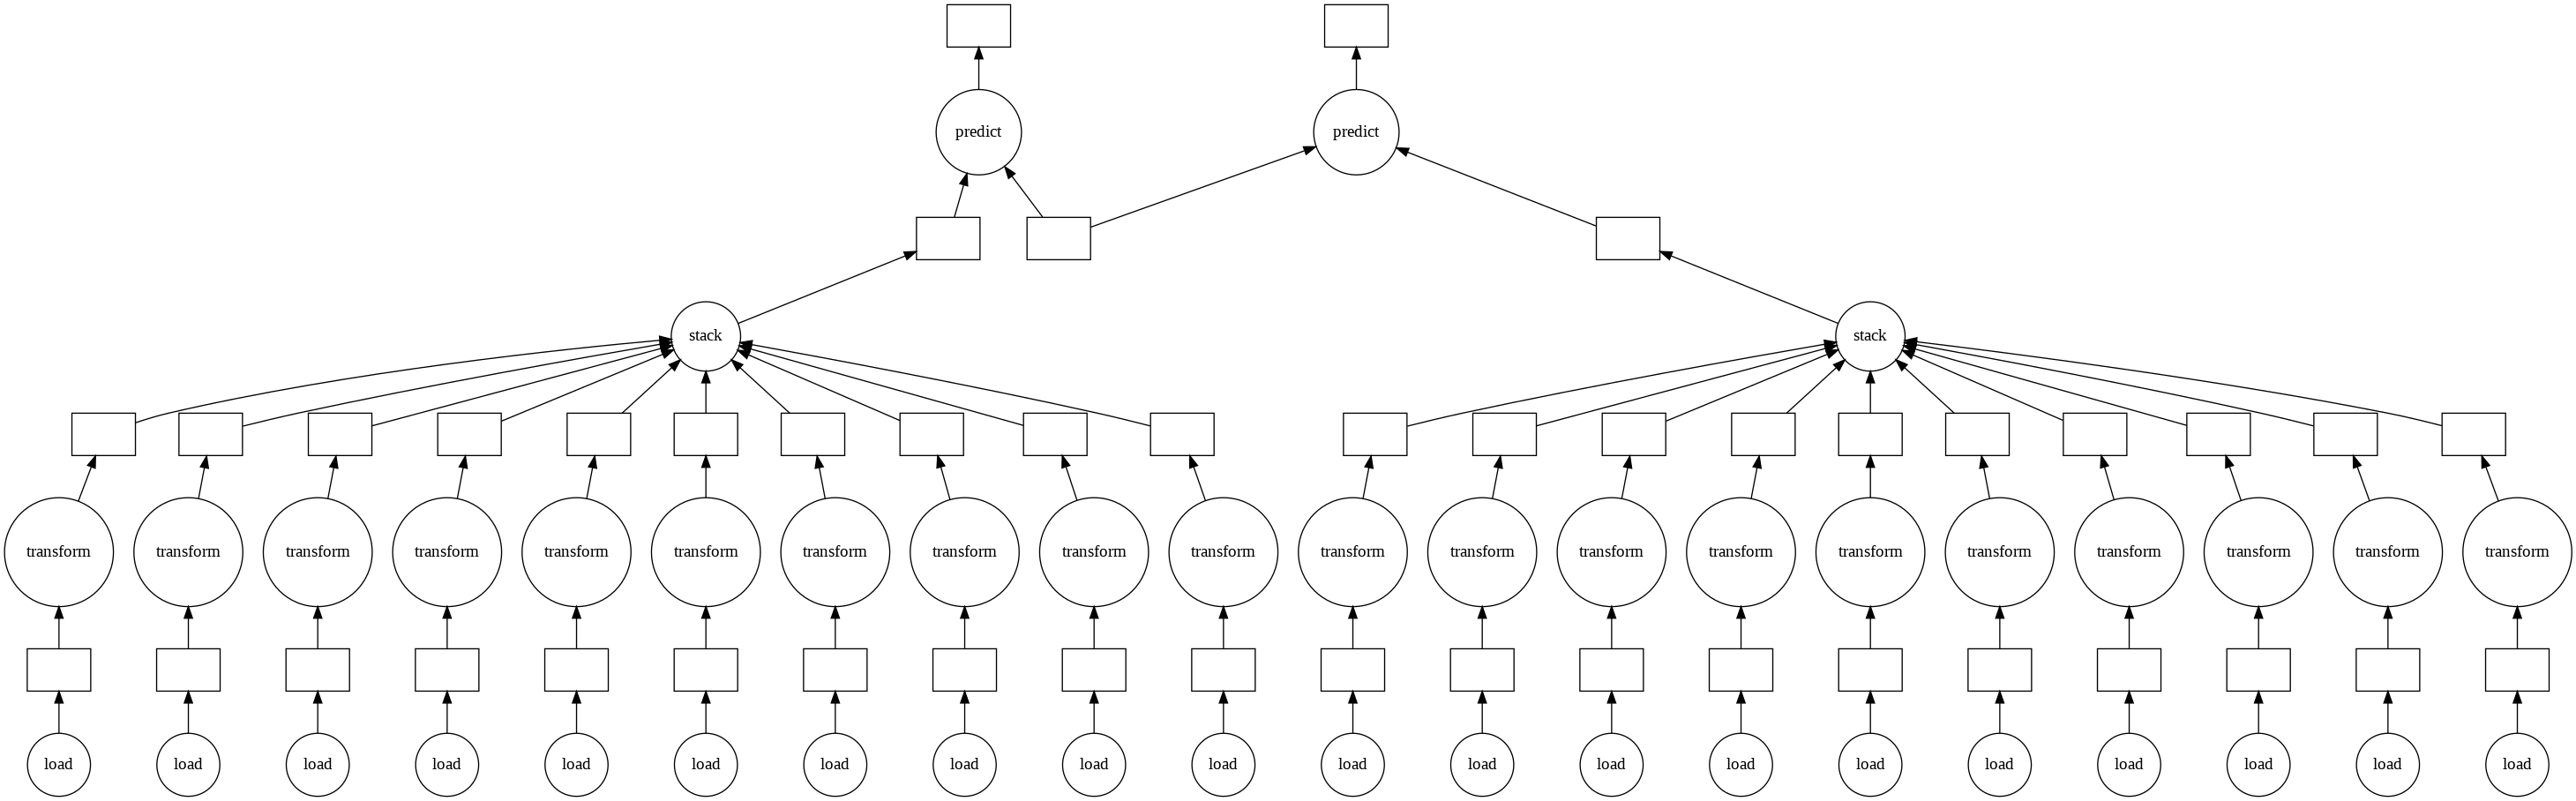

In [16]:
predictions = [predict(batch, dmodel) for batch in batches]
dask.visualize(predictions[:2])

## Execute remotely

In [17]:
predictions = dask.compute(*predictions)
predictions

FileNotFoundError: ignored

KilledWorker: ignored

In [34]:
print(results)

(<function predict_zeros at 0x7f2da0c687a0>,)


## Execute locallly

In [30]:

def predict_eager(batch, model):
    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted
 
batches_eager = [torch.stack(batch)
           for batch in toolz.partition_all(10, tensors_eager)]

print(type(batches_eager))
print(type(batches_eager[0]))
print(batches_eager[0].shape)

<class 'list'>
<class 'torch.Tensor'>
torch.Size([10, 3, 224, 224])


In [26]:
predictions = [predict_eager(batch, model) for batch in batches_eager]

In [28]:

print(len(predictions))
print(predictions)

16
[array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1]), array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1]), array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1]), array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1]), array([1, 1, 1])]


## Execute locally on dummy input

In [39]:

def predict_zeros_eager(model):
    batch = torch.zeros([10, 3, 224, 224])
    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted
    
pred_zeros = predict_zeros_eager(model)
predictions = [pred_zeros, pred_zeros]
results = predictions
print(results)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


## Execute remotely with no data transfer


In [40]:
@dask.delayed
def predict_zeros(model):
    batch = torch.zeros([10, 3, 224, 224])
    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted
    
pred_zeros = predict_zeros(dmodel)
predictions = [pred_zeros, pred_zeros]
results = dask.compute(*predictions)

KilledWorker: ignored

In [ ]:
print(results)